In [243]:
import sys
import os

sys.path.append(os.path.abspath('D:\ITC\РНФ_Курганский_2024\pythonProject\Mars\mars'))

import numpy as np
import torch
from torch import nn
import math

import spin_system, utils, particles, res_field_algorithm, constants, spectral_integration, mesher, spectra_manager, particles
from visualization import levels_plot, transitions_plot, spin_system_plot
from population import time_population, tr_utils, transform
import population

from importlib import reload

from spectra_manager import TruncatedSpectraCreatorTimeResolved, PostSpectraProcessing,TimeResolvedIntensitiesCalculator, ParamSpec
from spectral_integration import SpectraIntegratorEasySpinLikeTimeResolved, BaseSpectraIntegrator
from spectra_manager import BaseSpectraCreator

import optimization
import spectra_processing

import save_procedures

import matplotlib.pyplot as plt

reload(spectral_integration)
reload(spectra_manager)

<module 'spectra_manager' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\Mars\\mars\\spectra_manager.py'>

In [244]:
mesh = mesher.DelaunayMeshNeighbour(9, interpolate=False)

g_tensor = spin_system.Interaction((2.00, 2.23, 2.50))
D = spin_system.DEInteraction((1000000000, 10))

base_spin_system = spin_system.SpinSystem(
    electrons=[1.0], g_tensors = [g_tensor], electron_electron=[(0,0,D)])

sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=2e4, gauss=0.001, lorentz=0.001, mesh=mesh)
spect_creator = spectra_manager.StationarySpectraCreator(freq=9.8*1e9, sample=sample, harmonic=1)

fields = torch.linspace(0.2, 0.5, 6000)
spec = spect_creator(sample, fields)

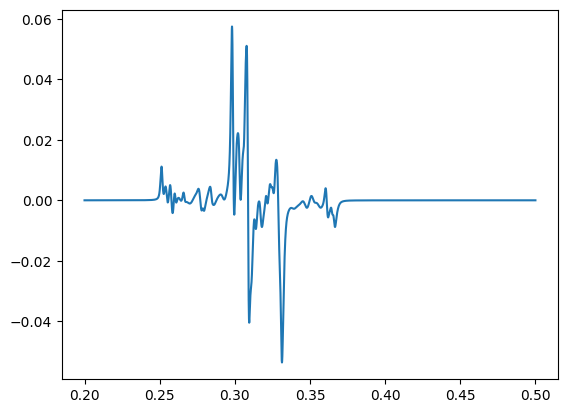

In [245]:
plt.plot(fields.numpy(), spec.numpy())
plt.show()

In [222]:
spec

tensor([3.1343e-06, 3.1406e-06, 3.1469e-06,  ..., 3.1166e-06, 3.1220e-06,
        3.1284e-06])

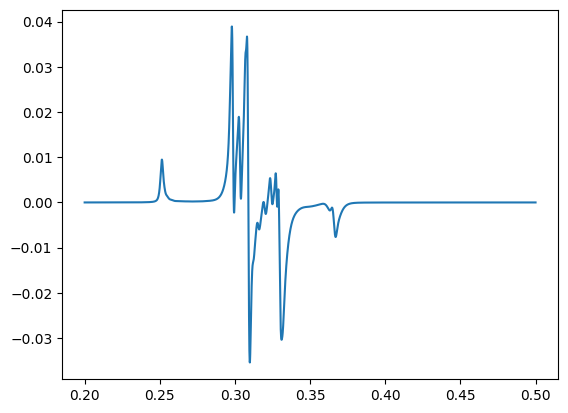

In [223]:
plt.plot(fields.numpy(), spec.numpy())
plt.show()

# General approach

There are next steps to create sample instance
1) Set electrons and nuclei
2) Create all nessusary interactions
3) Create spin-system
4) Create sample
5) Compute spectra.

We will follow these point to create spectra

### LESSON 1. Interaction / DEInteraction

In MarS, you can create an interaction between any two particles. Generally, an interaction involves:
1) principal values. These can be specified as isotropic, axial, orthorhombic, or in D-E notation (for DEInteraction);
2) three Euler angles;
3) strains. By default, strains are uncorrelated. The main difference between Interaction and DEInteraction is the strains notation. For DEInteraction, there are two strains parameters: D, E, for Interaction these parameters are AX, AY, AZ

Let's create interaction between two electrons

In [10]:
interaction_J = spin_system.Interaction(constants.unit_converter(1.0, "cm-1_to_Hz"))
dd = spin_system.DEInteraction([100 * 1e6, 10 * 1e6])

tot = interaction_J + dd

Here we wrote dipole-dipole interaction in DE notation, and exchange interaction. Note, you can sum up interactions.

Then, let's create spin system of two electrons connected by this interaction. Also, let's add zeeman interaction

In [11]:
g_tensor = spin_system.Interaction((2.02, 2.04, 2.06))

base_spin_system = spin_system.SpinSystem(
    electrons=[1/2, 1/2], g_tensors = [g_tensor, g_tensor], electron_electron=[(0, 1, tot)])

electron_electron takes the position of two connecteded electrons. Also it cab be Zero Field splitting. In this case idx_1 == idx_2

Then, let's create sample. We can set hamiltonina strain, gauss, lorentz. 
MarS doesn't have the determination of symmetry. So, for axial symmetery You should set the mesh by hand.
By default the mesh is half of shpere

In [24]:
sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=5e7, gauss=0.001, lorentz=0.001)
spect_creator = spectra_manager.StationarySpectraCreator(freq=9.8*1e9, sample=sample)

fields = torch.linspace(0.30, 0.4, 3000)
spec = spect_creator(sample, fields)

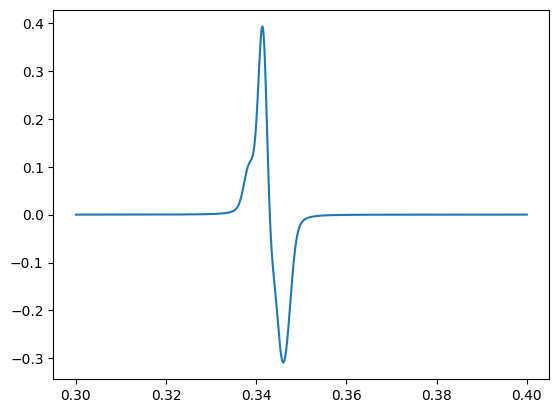

In [25]:
plt.plot(fields.numpy(), spec.numpy())
plt.show()

MarS supports print of a lot of different objects: interactions, spin systems, samples

In [ ]:
print(tot)

In [ ]:
print(base_spin_system)

In [ ]:
print(sample)

In [ ]:
Since MarS is based on torch, it is possible to compute everythin on cuda

In [32]:
device =  torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


In [ ]:
sample = sample.to(device)
spect_creator = spect_creator.to(device)

fields = torch.linspace(0.30, 0.4, 3000, device=device)
spec = spect_creator(sample, fields)

In [ ]:
plt.plot(fields.to("cpu").numpy(), spec.to("cpu").numpy())
plt.show()

It is possible to save data in several formats including EasySpin format

In [ ]:
import pandas as pd
fields = fields.numpy()
spec = spec.numpy()


data_frame = pd.DataFrame({"field": fields, "spec": spec})
data_frame.to_csv("D:\ITC\РНФ_Курганский_2024\qulity_spectra.csv", header=False, index=False)
save_procedures.save("D:\ITC\РНФ_Курганский_2024\example.mat", sample, spec_creat, fields, format_type="easyspin")

### dipole-dipole

In [64]:
mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2* np.pi),
                                    initial_grid_frequency=15,
                                    interpolate=False, interpolation_grid_frequency=70)

def build_sample(
    J, g_cu_chain, g_cu_branching, orient_side, orient_up, mesh, gauss, lorentz
) -> spin_system.MultiOrientedSample:

        # g-tensor components
        g_cu_chain_tensor = torch.tensor(g_cu_chain)
        g1_frame = orient_side
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor, g1_frame)
        
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor)
        
        g_cu_branching = torch.tensor(g_cu_branching)
        orient_up = orient_up
        zeem_branching = spin_system.Interaction(g_cu_branching)
        zeem_branching = spin_system.Interaction(g_cu_branching)
        
        e_chain = particles.Electron(spin=0.5)
        e_branching = particles.Electron(spin=0.5)
        
        D, E = constants.unit_converter(0.1, "cm-1_to_Hz"), constants.unit_converter(0.003, "cm-1_to_Hz")
        J = J # Because 2 S1 S2
        J = (J * 100) * 3 * 1e8
        ee_int_chain = spin_system.Interaction(J) + spin_system.DEInteraction((D, E))
        print(ee_int_chain)
        
        system = spin_system.SpinSystem(
            electrons=[e_chain, e_branching],
            g_tensors=[zeem_chain, zeem_branching],
            electron_electron=[
                (0, 1, ee_int_chain)
            ]
        )

        # Homogeneity strain
        
        return system, spin_system.MultiOrientedSample(system, torch.tensor([5e7, 5e7, 5e7]), gauss, lorentz, mesh)

In [65]:
system, sample = build_sample(J, g_cu_chain, g_cu_branching, orien_side_up, orien_chain_left, mesh, gauss, lorentz)

Principal values: [-9.09e+08, -1.09e+09, 2.00e+09]
Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
Strain: None


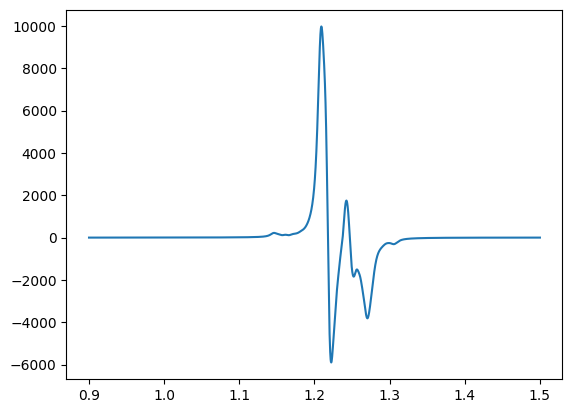

In [66]:
fields_1 = torch.linspace(0.9, 1.5, 3000)
freq = torch.tensor(38 * 1e9)
temp = 1
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)

plt.plot(fields_1.numpy(), spec_1.numpy())

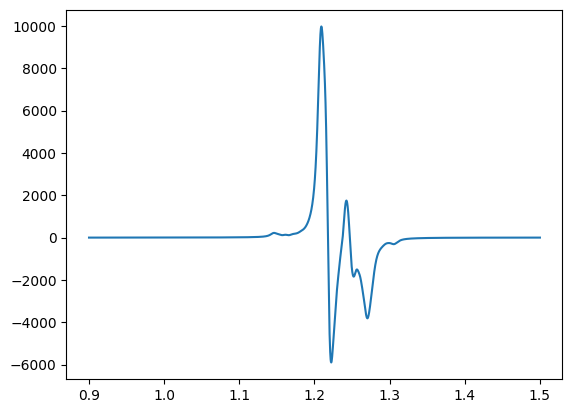

In [67]:
fields_1 = torch.linspace(0.9, 1.5, 3000)
freq = torch.tensor(38 * 1e9)
temp = 1
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)

plt.plot(fields_1.numpy(), spec_1.numpy())

In [68]:
import pandas as pd
fields_1 = fields_1.numpy()
spec_1 = spec_1.numpy()


data_frame = pd.DataFrame({"field": fields_1, "spec": spec_1})
data_frame.to_csv("D:\ITC\РНФ_Курганский_2024\qulity_spectra.csv", header=False, index=False)
save_procedures.save("D:\ITC\РНФ_Курганский_2024\example.mat", sample, spec_creat, fields_1, format_type="easyspin")

(0, 1)


### D-E interaction

In [10]:
dtype = torch.float64

In [11]:
def build_sample(
    J, g_cu_chain, g_cu_branching, orient_side, orient_up, mesh, gauss, lorentz
) -> spin_system.MultiOrientedSample:

        # g-tensor components
        g_cu_chain_tensor = torch.tensor(g_cu_chain, dtype=dtype)
        g1_frame = orient_side
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor, frame=torch.tensor([1.0, 1.0, 1.0]), dtype=dtype)
        
        g_cu_branching = torch.tensor(g_cu_branching, dtype=dtype)
        orient_up = orient_up
        zeem_branching = spin_system.Interaction(g_cu_branching, dtype=dtype)
        
        e_chain = particles.Electron(spin=1.0)
        e_branching = particles.Electron(spin=0.5)
        
        D, E = constants.unit_converter(0.1, "cm-1_to_Hz"), constants.unit_converter(0.0, "cm-1_to_Hz")

        ee_int_chain = spin_system.DEInteraction((D, E))
        ee_int_exchange = spin_system.Interaction(-2*constants.unit_converter(J, "cm-1_to_Hz"),)
        
        system = spin_system.SpinSystem(
            electrons=[e_chain, e_branching],
            g_tensors=[zeem_chain, zeem_branching],
            electron_electron=[
                (0, 0, ee_int_chain), (0, 1, ee_int_exchange)
            ], dtype=dtype
        )

        # Homogeneity strain
        
        return system, spin_system.MultiOrientedSample(system, torch.tensor([0.0, 0.0, 0.0], dtype=dtype), gauss, lorentz, mesh, dtype=dtype)

In [12]:
dtype = torch.float64
mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2* np.pi),
                                    initial_grid_frequency=45,
                                    interpolate=True, interpolation_grid_frequency=90, dtype=dtype)

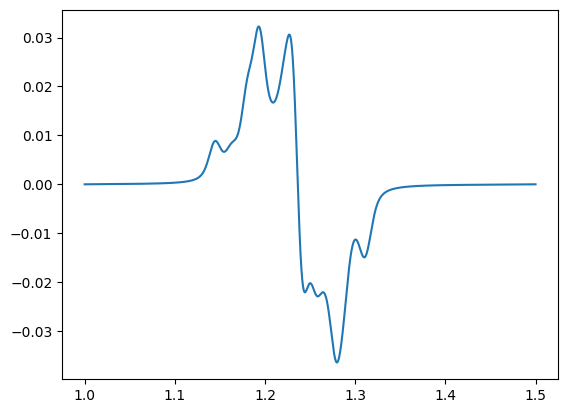

In [13]:
J = -5.0
g_cu_chain = [2.1, 2.2, 2.3]
g_cu_branching = [2.1, 2.2, 2.3]
gauss = torch.tensor(0.01)
lorentz = torch.tensor(0.01)

system, sample = build_sample(J, g_cu_chain, g_cu_branching, orien_side_up, orien_chain_left, mesh, gauss, lorentz)

fields_1 = torch.linspace(1.0, 1.50, 3000, dtype=dtype)
freq = torch.tensor(38 * 1e9, dtype=dtype)
temp = 100
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp, dtype=dtype)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)

plt.plot(fields_1.numpy(), spec_1.numpy())

### Nuclei

In [22]:
dtype = torch.float64

In [26]:
def build_sample(
    J, g_cu_chain, g_cu_branching, orient_side, orient_up, mesh, gauss, lorentz
) -> spin_system.MultiOrientedSample:

        # g-tensor components
        g_cu_chain_tensor = torch.tensor(g_cu_chain, dtype=dtype)
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor, dtype=dtype)
        
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor, dtype=dtype)
        
        g_cu_branching = torch.tensor(g_cu_branching, dtype=dtype)
        orient_up = orient_up
        zeem_branching = spin_system.Interaction(g_cu_branching, dtype=dtype)
        
        e_chain = particles.Electron(spin=1.0)
        e_branching = particles.Electron(spin=0.5)
        A_interaction = spin_system.Interaction((1e7, 1e7, 1e9), dtype=dtype)

        
        system = spin_system.SpinSystem(
            electrons=[e_chain],
            nuclei = ["14N", "14N"],
            g_tensors=[zeem_chain],
            electron_nuclei=[(0, 0, A_interaction), (0, 1, A_interaction)], dtype=dtype
        )

        # Homogeneity strain
        
        return system, spin_system.MultiOrientedSample(system, torch.tensor([0.0, 0.0, 0.0]), gauss, lorentz, mesh, dtype=dtype)

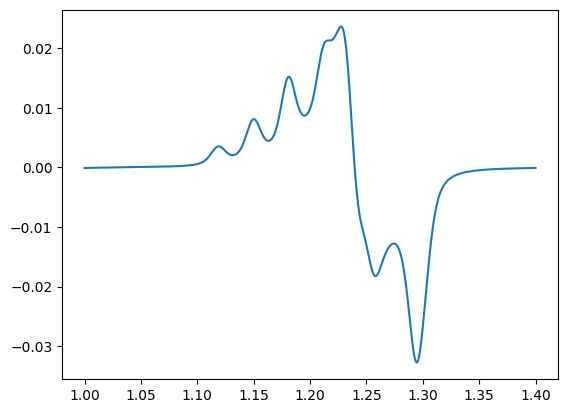

In [30]:
mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2* np.pi),
                                    initial_grid_frequency=45, 
                                    interpolate=True, interpolation_grid_frequency=100, dtype=dtype)
orien_side_up = torch.tensor(
    [
        [0.8859114, 0.0008034, 0.4638538],
        [0.0005397, -0.9999996, 0.0007013],
        [0.4638541, -0.000371, -0.8859115],]
)

orien_chain_left = torch.tensor(
    [
        [0.744169, 0.4552341, -0.4888501],
        [0.3236334, -0.8859029, -0.3323212],
        [-0.5843577, 0.0890949, -0.8065904]
    ]
)


J = -0.0
g_cu_chain = [2.1, 2.2, 2.3]
g_cu_branching = [2.2, 2.2, 2.2]
gauss = torch.tensor(0.01)
lorentz = torch.tensor(0.01)
system, sample = build_sample(J, g_cu_chain, g_cu_branching, orien_side_up, orien_chain_left, mesh, gauss, lorentz)

fields_1 = torch.linspace(1.0, 1.40, 3000)
freq = torch.tensor(38 * 1e9)
temp = 100
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp, dtype=dtype)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)

plt.plot(fields_1.numpy(), spec_1.numpy())

In [ ]:
import pandas as pd
fields_1 = fields_1.numpy()
spec_1 = spec_1.numpy()


data_frame = pd.DataFrame({"field": fields_1, "spec": spec_1})
data_frame.to_csv("D:\ITC\РНФ_Курганский_2024\qulity_spectra.csv", header=False, index=False)
save_procedures.save("D:\ITC\РНФ_Курганский_2024\example.mat", sample, spec_creat, fields_1, format_type="easyspin")

In [24]:
reload(spectral_integration)
reload(spin_system)
reload(population)
reload(population.stationary_population)
reload(optimization.fitter)
reload(optimization.objectives)
reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(tr_utils)
reload(spectra_manager)
reload(spin_system)
reload(res_field_algorithm)
reload(optimization)
reload(mesher.general_mesh)
reload(mesher)
reload(mesher.delanay_neigbour)


reload(spin_system_plot)
reload(save_procedures)

<module 'save_procedures' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\save_procedures.py'>

In [139]:
out = save_procedures.load("D:\ITC\РНФ_Курганский_2024\example.mat", format_type="easyspin")

In [140]:
sample = out["sample"]

In [142]:
print(sample)

SPIN SYSTEM SUMMARY

PARTICLES:
--------------------
Electrons (2):
  e0: S=1.0 
Principal values: [2.1000, 2.2000, 2.3000]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None
  e1: S=0.5 
Principal values: [2.2000, 2.2000, 2.2000]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None

Nuclei (2):
  n0: I=1.0
  n1: I=1.0

SYSTEM PROPERTIES:
--------------------
Hilbert space dimension: 54
Configuration shape: ()

INTERACTIONS (5 total):
------------------------------

Electron-Nucleus (4):
  1. e0 ↔ n0:
      Principal values: [1.00e+07, 1.00e+07, 1.00e+09]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None
  2. e0 ↔ n1:
      Principal values: [1.00e+07, 1.00e+07, 1.00e+09]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None
  3. e1 ↔ n0:
      Principal values: [1.00e+07, 1.00e+07, 1.00e+09]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None
  4. e1 ↔

In [4]:
dtype = torch.float64

mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2* np.pi),
                                    initial_grid_frequency=15, 
                                    interpolate=True, interpolation_grid_frequency=20, dtype=dtype)

g_tensor = spin_system.Interaction((2.12, 2.12, 2.12), dtype=dtype)
A_tensor = spin_system.Interaction(285*1e6, dtype=dtype)

ZFS = spin_system.DEInteraction([2230*1e6, 0.0*1e6])
base_spin_system = spin_system.SpinSystem(
    electrons=[5/2], nuclei=["55Mn"], g_tensors = [g_tensor], electron_electron=[(0, 0, ZFS)], electron_nuclei=[(0, 0, A_tensor)], dtype=dtype
)


freq = torch.tensor(9.5 * 1e9)
temp = 3.5
sample = spin_system.MultiOrientedSample(spin_system=base_spin_system, ham_strain=5e9, mesh=mesh, dtype=dtype)
fields = torch.linspace(0.0, 1.0, 2000)
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp, dtype=dtype, harmonic=0)

with torch.no_grad():
    spec = spec_creat(sample, fields)

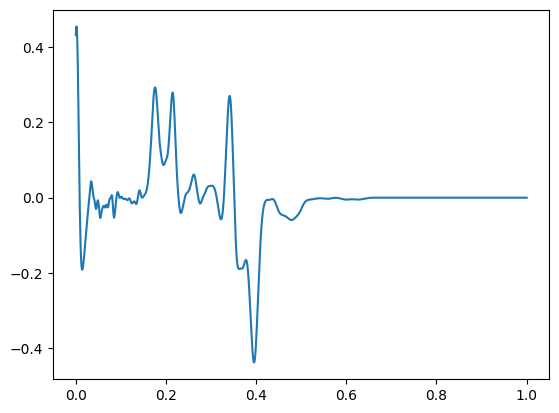

In [3]:
plt.plot(fields.numpy(), spec.numpy())